In [1]:
import pandas as pd
import pickle
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.conferences import Conferences
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rnd
from utils import  score_table
import importlib

#import argparse

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.optim import ClippedAdam
from torch.distributions import constraints

In [2]:
majorConfs = ["big-12","Big 12",
              "big-10","Big Ten","big-ten",
              "sec","SEC",
              "big-east","Big East",
              "pac-12","Pac-12",
              "acc","ACC",
              "wcc", "WCC"]
confNameNorm = {"Big 12":"big-12",
              "Big Ten":"big-ten",
              "big-ten":"big-ten",
              "SEC":"sec",
              "Big East":"big-east",
              "Pac-12":"pac-12",
              "ACC":"acc",
              "WCC":"wcc"}
def getDataForTeams(teams) :
    dataset = pd.DataFrame()
    for team in teams:
        if team.conference in majorConfs:
            tgDF = team.schedule.dataframe
            tgDF['team_name'] = team.name
            tgDF['team_conference'] = team.conference
            dataset = pd.concat([dataset,tgDF])     
    return dataset


In [31]:
#execute this cell to grab the data from the site
season_team_list = Teams("2022")
df = getDataForTeams(season_team_list)
compression_opts = dict(method='zip',
                        archive_name='outv3.csv')  
df.to_csv('data/bigconfs2022Season.zip', compression=compression_opts) 
pickle.dump( season_team_list, open( "data/teams2022.p", "wb" ) )

In [3]:
#execute this cell to just load the local files
season_team_list = pickle.load( open( "data/teams2022.p", "rb" ) )
c_opts = dict(method='zip')
df = pd.read_csv('data/bigconfs2022Season.zip',compression='zip')

In [4]:
bdf = df
#only have games between big conferences
bdf = bdf[bdf["opponent_conference"].isin(majorConfs)]
#get rid of duplicates
bdf.drop_duplicates(subset='boxscore_index', keep="first")
#drop Neutral games for now
bdf = bdf[bdf["location"].isin(["Home","Away"])]
#create Home, Away, neutral indicator columns
bdf = pd.get_dummies(bdf,prefix=['location'], columns = ['location'])
#create homeTeam, awayTeam columns
def addHomeTeamColumn(row):
    if(row['location_Home'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['HomeTeam'] = bdf.apply(addHomeTeamColumn, axis=1)
def addAwayTeamColumn(row):
    if(row['location_Away'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['AwayTeam'] = bdf.apply(addAwayTeamColumn, axis=1)
#add in "HomePoints" , AwayPoints
def addHomePointsColumn(row):
    if(row['location_Home'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['HomePoints'] = bdf.apply(addHomePointsColumn, axis=1)
def addAwayPointsColumn(row):
    if(row['location_Away'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['AwayPoints'] = bdf.apply(addAwayPointsColumn, axis=1)

bdf["opponent_conference"].replace(confNameNorm, inplace=True)

#just big ten conference games
big10df = bdf.loc[(bdf["team_conference"]=='big-ten')&
                  (bdf['opponent_conference']=='big-ten')]

#rename columns
selector_d = {'date':'Date', 'HomeTeam':'HomeTeam', 'AwayTeam':'AwayTeam',
              'HomePoints':'FTHG', 'AwayPoints':'FTAG',
              'team_conference':'HomeConf','opponent_conference':'AwayConf'}
bdf = bdf.rename(columns=selector_d)[selector_d.values()]
bdf.reset_index(inplace=True, drop=True)
big10df = big10df.rename(columns=selector_d)[selector_d.values()]
big10df.reset_index(inplace=True, drop=True)
bdf.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HomeConf,AwayConf
0,"Wed, Dec 29, 2021",Alabama,Tennessee,73.0,68.0,sec,sec
1,"Wed, Jan 5, 2022",Florida,Alabama,70.0,83.0,sec,sec
2,"Sat, Jan 8, 2022",Missouri,Alabama,92.0,86.0,sec,sec
3,"Tue, Jan 11, 2022",Alabama,Auburn,77.0,81.0,sec,sec
4,"Sat, Jan 15, 2022",Mississippi State,Alabama,78.0,76.0,sec,sec


In [11]:
bdf['HomeConf'].unique().tolist()

['sec', 'pac-12', 'big-12', 'acc', 'wcc', 'big-east', 'big-ten']

In [15]:
[a for a in bdf['AwayConf'].unique().tolist() or bdf['HomeConf'].unique().tolist()]

['sec', 'big-12', 'wcc', 'pac-12', 'big-east', 'big-ten', 'acc']

In [36]:
big10df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HomeConf,AwayConf
0,"Fri, Dec 3, 2021",Illinois,Rutgers,86.0,51.0,big-ten,big-ten
1,"Mon, Dec 6, 2021",Iowa,Illinois,83.0,87.0,big-ten,big-ten
2,"Tue, Jan 4, 2022",Minnesota,Illinois,53.0,76.0,big-ten,big-ten
3,"Thu, Jan 6, 2022",Illinois,Maryland,76.0,64.0,big-ten,big-ten
4,"Tue, Jan 11, 2022",Nebraska,Illinois,71.0,81.0,big-ten,big-ten


In [37]:
big10df['Date'].max()

'Wed, Mar 2, 2022'

In [39]:
homeMean = df[df.location=='Home']['points_for'].mean()
awayMean = df[df.location=='Away']['points_for'].mean()
[homeMean,awayMean]

[74.80267794221282, 68.79452054794521]

In [ ]:
def transformData(data):
    pl_data = data

    ng = len(pl_data)  # number of games
    npr = 45  # predict the last 5 rounds of games
    ngob = ng - npr  # number of games to train

    pl_data = pl_data.rename(columns={"FTHG": "score1","FTAG":"score2",
                            "HomeTeam":"Home","AwayTeam":"Away"})

    teams = pl_data["Home"].unique()
    teams = pd.DataFrame(teams, columns=["Team"])
    teams["i"] = teams.index

    df = pd.merge(pl_data, teams, left_on="Home", right_on="Team", how="left")
    df = df.rename(columns={"i": "Home_id"}).drop("Team", axis=1)
    df = pd.merge(df, teams, left_on="Away", right_on="Team", how="left")
    df = df.rename(columns={"i": "Away_id"}).drop("Team", axis=1)

 
    df["split"] = np.where(df.index + 1 <= ngob, "train", "predict")

    print(df.head())

    return teams, df


In [33]:
#add here the hcm_id, acm_id calculations
def transformData2(data):
    pl_data = data

    ng = len(pl_data)  # number of games
    npr = 65  # predict the last 5 rounds of games
#    ngob = ng - npr  # number of games to train
    ngob = ng

    pl_data = pl_data.rename(columns={"FTHG": "score1","FTAG":"score2",
                            "HomeTeam":"Home","AwayTeam":"Away"})
    
    teams = pl_data["Home"].unique()
    teams = pd.DataFrame(teams, columns=["Team"])
    teams["i"] = teams.index

    df = pd.merge(pl_data, teams, left_on="Home", right_on="Team", how="left")
    df = df.rename(columns={"i": "Home_id"}).drop("Team", axis=1)
    df = pd.merge(df, teams, left_on="Away", right_on="Team", how="left")
    df = df.rename(columns={"i": "Away_id"}).drop("Team", axis=1)

    confs = pl_data["HomeConf"].unique() #assumes AwayConf set is a subset of homeconf set
    confs = pd.DataFrame(confs, columns=["Conf"])
    confs["j"] = confs.index

    df = pd.merge(df, confs, left_on="HomeConf", right_on="Conf", how="left")
    df = df.rename(columns={"j": "HomeConf_id"}).drop("Conf", axis=1)
    df = pd.merge(df, confs, left_on="AwayConf", right_on="Conf", how="left")
    df = df.rename(columns={"j": "AwayConf_id"}).drop("Conf", axis=1)

 
    df["split"] = np.where(df.index + 1 <= ngob, "train", "predict")

    print(df.head())

    return teams, confs, df


In [34]:
#tt,dd = transformData(big10df)
tt,cc,dd = transformData2(bdf)

                Date               Home       Away  score1  score2 HomeConf  \
0  Wed, Dec 29, 2021            Alabama  Tennessee    73.0    68.0      sec   
1   Wed, Jan 5, 2022            Florida    Alabama    70.0    83.0      sec   
2   Sat, Jan 8, 2022           Missouri    Alabama    92.0    86.0      sec   
3  Tue, Jan 11, 2022            Alabama     Auburn    77.0    81.0      sec   
4  Sat, Jan 15, 2022  Mississippi State    Alabama    78.0    76.0      sec   

  AwayConf  Home_id  Away_id  HomeConf_id  AwayConf_id  split  
0      sec        0       24            0            0  train  
1      sec        1        0            0            0  train  
2      sec        2        0            0            0  train  
3      sec        0        5            0            0  train  
4      sec        3        0            0            0  train  


In [23]:
dd.tail()

,Date,Home,Away,score1,score2,HomeConf,AwayConf,Home_id,Away_id,HomeConf_id,AwayConf_id,split
1771,"Sat, Feb 19, 2022",Connecticut,Xavier,72.0,61.0,big-east,big-east,60,62,5,5,predict
1772,"Wed, Feb 23, 2022",Providence,Xavier,99.0,92.0,big-east,big-east,61,62,5,5,predict
1773,"Sat, Feb 26, 2022",Xavier,Seton Hall,66.0,82.0,big-east,big-east,62,65,5,5,predict
1774,"Wed, Mar 2, 2022",St. John's (NY),Xavier,81.0,66.0,big-east,big-east,64,62,5,5,predict
1775,"Sat, Mar 5, 2022",Xavier,Georgetown,97.0,75.0,big-east,big-east,62,58,5,5,predict


In [35]:
len(dd[dd['split']=='predict'])

0

In [79]:
len(dd[dd['HomeConf']!=dd['AwayConf']])

164

In [67]:
tt

,Team,i
0,Alabama,0
1,Florida,1
2,Missouri,2
3,Mississippi State,3
4,Georgia,4
...,...,...
81,Michigan State,81
82,Michigan,82
83,Wisconsin,83
84,Penn State,84


In [26]:
cc

,Conf,j
0,sec,0
1,pac-12,1
2,big-12,2
3,acc,3
4,wcc,4
5,big-east,5
6,big-ten,6


In [ ]:
dd[dd['split']=='train']

In [31]:

class FoldedTransform(dist.transforms.AbsTransform):
    def log_abs_det_jacobian(self, x, y):
        return torch.zeros_like(x)

def model2(home_id, away_id, hcm_id, acm_id,score1_obs=None, score2_obs=None):
    # hyperpriors
    alpha = pyro.sample("alpha", dist.Normal(1.0, 3.0))
    sd_att = pyro.sample("sd_att", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    sd_def = pyro.sample("sd_def", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    #student t: degrees of freedom, mean, width
    #started with width = 2.5
    home = pyro.sample("home", dist.Normal(0.0, 2.0))  # home advantage
    #started with 1.0 for std

    nt   = len(np.unique(home_id))
    nhcm = len(np.unique(hcm_id))
    nacm = len(np.unique(acm_id))

    with pyro.plate("plate_conf_matchups_h", nhcm):
        hcm = pyro.sample("hcm", dist.Normal(0, 2.0))

    with pyro.plate("plate_conf_matchups_a", nacm):
        acm = pyro.sample("acm", dist.Normal(0, 2.0))

    # team-specific model parameters
    with pyro.plate("plate_teams", nt):
        attack = pyro.sample("attack", dist.Normal(0, sd_att))
        defend = pyro.sample("defend", dist.Normal(0, sd_def))

    # likelihood
    theta1 = torch.exp(alpha + home + hcm[hcm_id] + attack[home_id] - defend[away_id])
    theta2 = torch.exp(alpha + acm[acm_id] + attack[away_id] - defend[home_id])

    with pyro.plate("data", len(home_id)):
        pyro.sample("s1", dist.Poisson(theta1), obs=score1_obs)
        pyro.sample("s2", dist.Poisson(theta2), obs=score2_obs)

def guide2(home_id, away_id,hcm_id, acm_id,score1_obs=None, score2_obs=None):
    mu_locs = pyro.param("mu_loc", torch.tensor(0.0).expand(4))
    mu_scales = pyro.param("mu_scale", torch.tensor(0.1).expand(4), constraint=constraints.positive)

    pyro.sample("alpha",  dist.Normal(mu_locs[0], mu_scales[0]))
    pyro.sample("sd_att", dist.LogNormal(mu_locs[1], mu_scales[1]))
    pyro.sample("sd_def", dist.LogNormal(mu_locs[2], mu_scales[2]))
    pyro.sample("home",   dist.Normal(mu_locs[3], mu_scales[3]))  # home advantage

    nt   = len(np.unique(home_id))
    nhcm = len(np.unique(hcm_id))
    nacm = len(np.unique(acm_id))

    mu_team_locs = pyro.param("mu_team_loc", torch.tensor(0.0).expand(4, nt))
    mu_team_scales = pyro.param("mu_team_scale", torch.tensor(0.1).expand(4, nt), constraint=constraints.positive)

    with pyro.plate("plate_teams", nt):
        pyro.sample("attack", dist.Normal(mu_team_locs[0], mu_team_scales[0]))
        pyro.sample("defend", dist.Normal(mu_team_locs[1], mu_team_scales[1]))

    with pyro.plate("plate_conf_matchups_h", nhcm):
        pyro.sample("hcm", dist.Normal(mu_team_locs[2], mu_team_scales[2]))

    with pyro.plate("plate_conf_matchups_a", nacm):
        pyro.sample("acm", dist.Normal(mu_team_locs[3], mu_team_scales[3]))
        
        

def run_inference2(model, guide, home_id, away_id, hcm_id, acm_id,score1, score2, args):
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / args.num_iterations)

    svi = SVI(
        model=model2,
        guide=guide2,
        optim=ClippedAdam({"lr": args.learning_rate, "lrd": lrd}),
        loss=Trace_ELBO(num_particles=args.num_particles),
    )

    pyro.clear_param_store()  # clear global parameter cache
    pyro.set_rng_seed(args.rng_seed)

    advi_loss = []
    for j in range(args.num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(
            home_id=home_id,
            away_id=away_id,
            hcm_id=hcm_id, 
            acm_id=acm_id,
            score1_obs=score1.float(),
            score2_obs=score2.float(),
        )
        advi_loss.append(loss)
        if j % 100 == 0:
            print("[iteration %4d] loss: %.4f" % (j + 1, loss))

    print("Posterior: ")
    for i in pyro.get_param_store().items():
        print(i)

    fit = Predictive(model=model, guide=guide, num_samples=2000)(
        home_id=home_id, away_id=away_id, 
        hcm_id=hcm_id, acm_id=acm_id,
    )

    return fit

def runThePyroFit2(data,args):
    print("transforming data...")
    teams,confs, df =  transformData(data)
    train = df[df["split"] == "train"]

    print("Starting inference...")
    fit = run_inference2(
        model2,
        guide2,
        torch.tensor(train["Home_id"]),
        torch.tensor(train["Away_id"]),
        torch.tensor(train["HomeConf_id"]),
        torch.tensor(train["AwayConf_id"]),
        torch.tensor(train["score1"]),
        torch.tensor(train["score2"]),
        args,
    )
    return fit,teams,confs,df,train



In [80]:

class FoldedTransform(dist.transforms.AbsTransform):
    def log_abs_det_jacobian(self, x, y):
        return torch.zeros_like(x)

def model(home_id, away_id, score1_obs=None, score2_obs=None):
    # hyperpriors
    alpha = pyro.sample("alpha", dist.Normal(1.0, 3.0))
    sd_att = pyro.sample("sd_att", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    sd_def = pyro.sample("sd_def", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    #student t: degrees of freedom, mean, width
    #started with width = 2.5
    home = pyro.sample("home", dist.Normal(0.0, 2.0))  # home advantage
    #started with 1.0 for std
    nt = len(np.unique(home_id))

    # team-specific model parameters
    with pyro.plate("plate_teams", nt):
        attack = pyro.sample("attack", dist.Normal(0, sd_att))
        defend = pyro.sample("defend", dist.Normal(0, sd_def))

    # likelihood
    theta1 = torch.exp(alpha + home + attack[home_id] - defend[away_id])
    theta2 = torch.exp(alpha + attack[away_id] - defend[home_id])

    with pyro.plate("data", len(home_id)):
        pyro.sample("s1", dist.Poisson(theta1), obs=score1_obs)
        pyro.sample("s2", dist.Poisson(theta2), obs=score2_obs)

def guide(home_id, away_id, score1_obs=None, score2_obs=None):
    mu_locs = pyro.param("mu_loc", torch.tensor(0.0).expand(4))
    mu_scales = pyro.param("mu_scale", torch.tensor(0.1).expand(4), constraint=constraints.positive)

    pyro.sample("alpha", dist.Normal(mu_locs[0], mu_scales[0]))
    pyro.sample("sd_att", dist.LogNormal(mu_locs[1], mu_scales[1]))
    pyro.sample("sd_def", dist.LogNormal(mu_locs[2], mu_scales[2]))
    pyro.sample("home", dist.Normal(mu_locs[3], mu_scales[3]))  # home advantage

    nt = len(np.unique(home_id))
    #print("number of teams: ", nt)

    mu_team_locs = pyro.param("mu_team_loc", torch.tensor(0.0).expand(2, nt))
    mu_team_scales = pyro.param("mu_team_scale", torch.tensor(0.1).expand(2, nt), constraint=constraints.positive)

    with pyro.plate("plate_teams", nt):
        pyro.sample("attack", dist.Normal(mu_team_locs[0], mu_team_scales[0]))
        pyro.sample("defend", dist.Normal(mu_team_locs[1], mu_team_scales[1]))

def run_inference(model, guide, home_id, away_id, score1, score2, args):
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / args.num_iterations)

    svi = SVI(
        model=model,
        guide=guide,
        optim=ClippedAdam({"lr": args.learning_rate, "lrd": lrd}),
        loss=Trace_ELBO(num_particles=args.num_particles),
    )

    pyro.clear_param_store()  # clear global parameter cache
    pyro.set_rng_seed(args.rng_seed)

    advi_loss = []
    for j in range(args.num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(
            home_id=home_id,
            away_id=away_id,
            score1_obs=score1.float(),
            score2_obs=score2.float(),
        )
        advi_loss.append(loss)
        if j % 100 == 0:
            print("[iteration %4d] loss: %.4f" % (j + 1, loss))

    print("Posterior: ")
    for i in pyro.get_param_store().items():
        print(i)

    fit = Predictive(model=model, guide=guide, num_samples=2000)(
        home_id=home_id, away_id=away_id
    )

    return fit

def runThePyroFit(data,args):
    print("transforming data...")
    teams, df =  transformData(data)
    train = df[df["split"] == "train"]

    print("Starting inference...")
    fit = run_inference(
        model,
        guide,
        torch.tensor(train["Home_id"]),
        torch.tensor(train["Away_id"]),
        torch.tensor(train["score1"]),
        torch.tensor(train["score2"]),
        args,
    )
    return fit,teams,df,train

#def runThePyroCodeRest(data,args,fit):
def runThePyroCodeRest(fit,teams,df,train):
#    print("transforming data...")
#    teams, df =  transformData(data)
#    train = df[df["split"] == "train"]

#    print("Starting inference...")
#    fit = run_inference(
#        model,
#        guide,
#        torch.tensor(train["Home_id"]),
#        torch.tensor(train["Away_id"]),
#        torch.tensor(train["score1"]),
#        torch.tensor(train["score2"]),
#        args,
#    )

    print("Analyse posterior...")


    # Predicted goals and table
    predict = df[df["split"] == "predict"]
    #print("this many home_ids: " , predict.Home_id.unique())

    predictive = Predictive(
        model=model, guide=guide, num_samples=2000, return_sites=["s1", "s2"]
    )
 
    predicted_score = predictive(
        home_id=predict["Home_id"].values,
        away_id=predict["Away_id"].values,
    )

    predicted_full = predict.copy()
    predicted_full = predicted_full.assign(
        score1=predicted_score["s1"].mean(axis=0).round(),
        score1error=predicted_score["s1"].std(axis=0),
        score2=predicted_score["s2"].mean(axis=0).round(),
        score2error=predicted_score["s2"].std(axis=0),
    )

    predicted_full = train.append(
        predicted_full.drop(columns=["score1error", "score2error"])
    )

    print(score_table(df))
    print(score_table(predicted_full))

def qualityCalc(fit,teams,df,train):
    # Attack and defence
    quality = teams.copy()

    quality = quality.assign(
        attack=fit["attack"].mean(axis=0),
        attacksd=fit["attack"].std(axis=0),
        defend=fit["defend"].mean(axis=0),
        defendsd=fit["defend"].std(axis=0),
    )
    quality = quality.assign(
        attack_low=quality["attack"] - quality["attacksd"],
        attack_high=quality["attack"] + quality["attacksd"],
        defend_low=quality["defend"] - quality["defendsd"],
        defend_high=quality["defend"] + quality["defendsd"],
    )
    #gotta debug this
    return quality


In [36]:
class Args():
    learning_rate = 0.1
    num_particles = 1
    rng_seed = 1
    num_iterations = 2000

args=Args()
#runThePyroCode(big10df,args)
#fit,teams,df,train = runThePyroFit(big10df,args)
fit,teams,confs,df,train = runThePyroFit2(bdf,args)

transforming data...
                Date               Home       Away  score1  score2 HomeConf  \
0  Wed, Dec 29, 2021            Alabama  Tennessee    73.0    68.0      sec   
1   Wed, Jan 5, 2022            Florida    Alabama    70.0    83.0      sec   
2   Sat, Jan 8, 2022           Missouri    Alabama    92.0    86.0      sec   
3  Tue, Jan 11, 2022            Alabama     Auburn    77.0    81.0      sec   
4  Sat, Jan 15, 2022  Mississippi State    Alabama    78.0    76.0      sec   

  AwayConf  Home_id  Away_id  HomeConf_id  AwayConf_id  split  
0      sec        0       24            0            0  train  
1      sec        1        0            0            0  train  
2      sec        2        0            0            0  train  
3      sec        0        5            0            0  train  
4      sec        3        0            0            0  train  
Starting inference...


ValueError: Shape mismatch inside plate('plate_conf_matchups_h') at site hcm dim -1, 7 vs 86
             Trace Shapes:      
              Param Sites:      
                    mu_loc     4
                  mu_scale     4
               mu_team_loc  4 86
             mu_team_scale  4 86
             Sample Sites:      
                alpha dist     |
                     value     |
               sd_att dist     |
                     value     |
               sd_def dist     |
                     value     |
                 home dist     |
                     value     |
          plate_teams dist     |
                     value 86  |
               attack dist 86  |
                     value 86  |
               defend dist 86  |
                     value 86  |
plate_conf_matchups_h dist     |
                     value  7  |

In [72]:
runThePyroCodeRest(fit,teams,df,train)

Analyse posterior...


ValueError: Shape mismatch inside plate('plate_teams') at site attack dim -1, 33 vs 86
   Trace Shapes:      
    Param Sites:      
          mu_loc     4
        mu_scale     4
     mu_team_loc  2 86
   mu_team_scale  2 86
   Sample Sites:      
      alpha dist     |
           value     |
     sd_att dist     |
           value     |
     sd_def dist     |
           value     |
       home dist     |
           value     |
plate_teams dist     |
           value 33  |

In [82]:
qDF = qualityCalc(fit,teams,df,train)
qDF.head()

,Team,i,attack,attacksd,defend,defendsd,attack_low,attack_high,defend_low,defend_high
0,Alabama,0,1.646076,0.018735,-1.281364,0.018209,1.627341,1.664810,-1.299573,-1.263154
1,Florida,1,1.482568,0.018521,-1.152242,0.018586,1.464047,1.501089,-1.170827,-1.133656
2,Missouri,2,1.433841,0.019152,-1.202083,0.017656,1.414689,1.452993,-1.219740,-1.184427
3,Mississippi State,3,1.512979,0.019134,-1.179430,0.018535,1.493846,1.532113,-1.197965,-1.160895
4,Georgia,4,1.538551,0.018610,-1.348243,0.017279,1.519941,1.557161,-1.365522,-1.330964


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'defend strength')

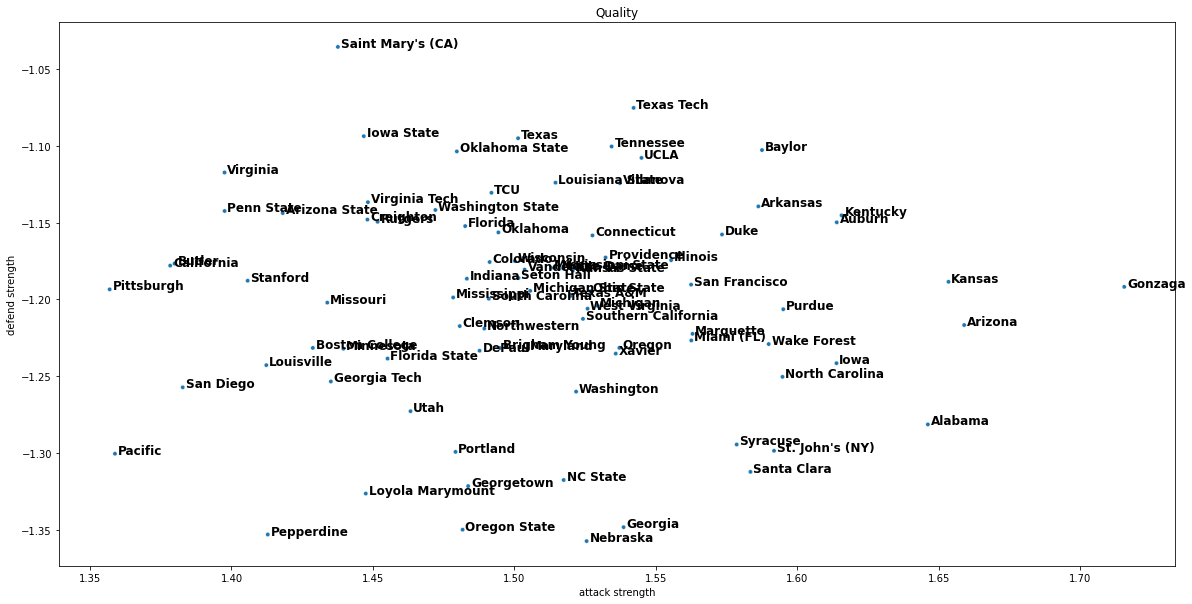

In [83]:

plt.figure(figsize=(20,10))
p1 = sns.scatterplot('attack', # Horizontal axis
       'defend', # Vertical axis
       data=qDF, # Data source
       size = 8,
       legend=False)  

for line in range(0,qDF.shape[0]):
     p1.text(qDF.attack[line]+0.001, qDF.defend[line], 
     qDF.Team[line], horizontalalignment='left', 
     size='large', color='black', weight='semibold')

plt.title('Quality')
# Set x-axis label
plt.xlabel('attack strength')
# Set y-axis label
plt.ylabel('defend strength')

In [54]:
#now get the probability of Michigan State winning vs. Michigan
#it looks like I have to do a full set of teams
#just put in a full set of combinations
#generate an array with just each team once
predictAll = df[df["split"] == "predict"]
predict = predictAll.drop(predictAll.tail(7).index,inplace=False)
predictive = Predictive(
    model=model, guide=guide, num_samples=30000, return_sites=["s1", "s2"]
)
msuMich = pd.DataFrame({'Home_id':[9,0,1,2,3,4,5,6,7,8,9,10,11,12,13],
        'Away_id':[7,0,1,2,3,4,5,6,7,8,9,10,11,12,13]})
predicted_score = predictive(
    home_id=msuMich["Home_id"].values,
    away_id=msuMich["Away_id"].values,
)


In [56]:
um = predicted_score["s1"][0].tolist()
msu = predicted_score["s2"][0].tolist()


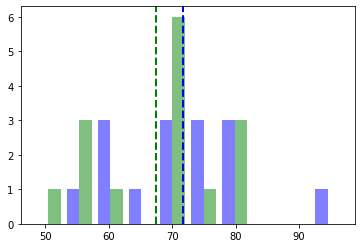

In [57]:
def meanl(lst):
    return sum(lst) / len(lst)
plt.hist([um, msu], color=['b','g'], alpha=0.5)
plt.axvline(meanl(um), color='b', linestyle='dashed', linewidth=2)
plt.axvline(meanl(msu), color='g', linestyle='dashed', linewidth=2)


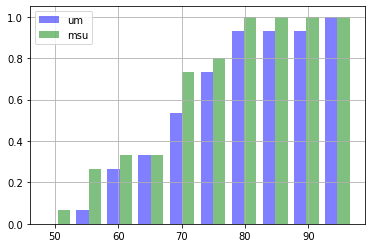

In [58]:
#CDF
plt.hist([um, msu],label=['um','msu'] ,color=['b','g'], alpha=0.5,density=True, cumulative=True)
plt.grid()
plt.legend(loc='best')

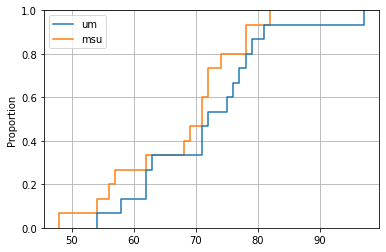

In [60]:
s1=um
s2=msu
sDF = pd.DataFrame({'um':s1,'msu':s2})
sns.ecdfplot(sDF)
plt.grid()

In [61]:
n=100
sams1=rnd.choices(s1, k=n)
sams2=rnd.choices(s2, k=n)
overunder = [p1+p2 for p1 in sams1 for p2 in sams2]
spread    = [p1-p2 for p1 in sams1 for p2 in sams2]
samsDF = pd.DataFrame({'overunder':overunder,'spread':spread})

<AxesSubplot:ylabel='Count'>

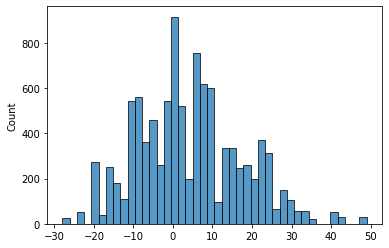

In [62]:
sns.histplot(spread)

<AxesSubplot:ylabel='Count'>

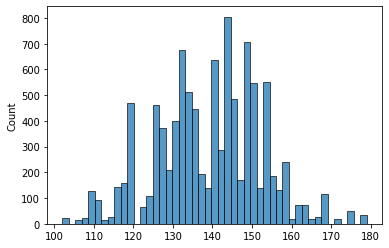

In [63]:
sns.histplot(overunder)

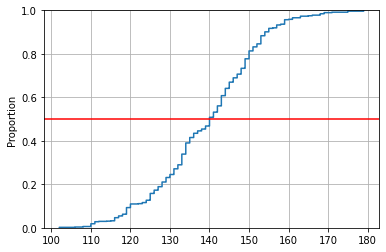

In [73]:
sns.ecdfplot(overunder)
plt.grid()
plt.axhline(y=0.5, color='r', linestyle='-')

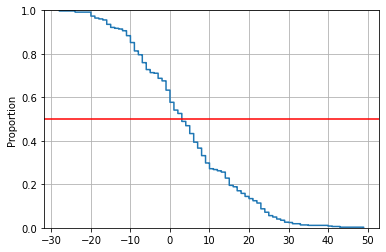

In [74]:
#probability of team1 wining by at least x points
sns.ecdfplot(spread,complementary=True)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.grid()

In [ ]:
#how to double the last 10 games